In [11]:
import numpy as np
import netCDF4
import subprocess
from operator import itemgetter
import gsw
from matplotlib import pyplot as plt

# read the database of argo profile data as set up
cur_dir = subprocess.check_output("pwd", shell=True)[:-1]
dest_dir = cur_dir + "/jerupiga/"
dbase = np.load(dest_dir + "argo_profile_info_database.npz")["dbase"]

In [12]:
print len(dbase)
match = dbase[dbase["ps_qc"] != 'F']
print len(match)
match = match[match["ps_qc"] != 'E']
print len(match)
match = match[match["ps_qc"] != 'D']
print len(match), len(match[np.logical_or(match["pt_qc"] == 'E', match["pt_qc"] == 'F')]), len(match[match["pt_qc"]=="F"])
# match = match[np.logical_or(match["pt_qc"] != 'F', match["pt_qc"] != 'E')]
match = match[match["pt_qc"] != 'F']
print len(match), len(match[np.logical_or(match["pt_qc"] == 'D', match["pp_qc"] == 'F')]), len(match[match["pp_qc"]=="E"])
# match = dbase[np.logical_and(dbase["lon"] >= 75., dbase["lon"] <= 85.)]
match = match[np.logical_and(match["lon"] >= 78., match["lon"] <= 82.)]
match = match[np.logical_and(match["lat"] <= -6., match["lat"] >= -10.)]
# match = match[np.logical_or(match["month"] <= 4, match["month"] >= 11)]
print len(match)
match = match[np.logical_and(match["pmin"] <= 50., match["pmax"] >= 200.)]
# match = match[np.logical_or(match["pt_qc"] != "D", match["ps_qc"] != "D")]
print len(match)

17486
15897
15886
15881 2 2
15879 0 0
626
626


/home/saulo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in greater_equal
/home/saulo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in less_equal


In [13]:
daids = list(set(match["floatid"]))  # has to be same as filestoread, could come before pathstofile
pathstofiles = [dest_dir + m + "_prof.nc" for m in daids]

In [344]:
def fillup_argolist():
    argo_profs = []
    append = argo_profs.append
    MA = np.ma.masked_invalid
    for n in range(0, len(daids)):
        argo_data = netCDF4.Dataset(pathstofiles[n])
        #  argo_data = netCDF4.Dataset(filestoread[n])
        prof_idxs = match[match["floatid"]==daids[n]]["prof_n"]
        # start pulling off data, should go all into some container class type (which would have limited functionality):
        juld = argo_data.variables['JULD'][prof_idxs]  # at the moment contains multiple profiles
        juld_qc = argo_data.variables['JULD_QC'][prof_idxs]
        juld_loc = argo_data.variables['JULD_LOCATION'][prof_idxs]
        lat = argo_data.variables['LATITUDE'][prof_idxs]
        lon = argo_data.variables['LONGITUDE'][prof_idxs]
        pos_qc = argo_data.variables['POSITION_QC'][prof_idxs]
        prof_pres_qc = argo_data.variables['PROFILE_PRES_QC'][prof_idxs]
        prof_sal_qc = argo_data.variables['PROFILE_PSAL_QC'][prof_idxs]
        prof_temp_qc = argo_data.variables['PROFILE_TEMP_QC'][prof_idxs]
        pres = argo_data.variables['PRES'][prof_idxs, :]
        pres_qc = argo_data.variables['PRES_QC'][prof_idxs, :]
        pres_a = argo_data.variables['PRES_ADJUSTED'][prof_idxs, :]
        pres_a_qc = argo_data.variables['PRES_ADJUSTED_QC'][prof_idxs, :]
        pres_a_er = argo_data.variables['PRES_ADJUSTED_ERROR'][prof_idxs, :]
        sal = argo_data.variables['PSAL'][prof_idxs, :]
        sal_qc = argo_data.variables['PSAL_QC'][prof_idxs, :]
        sal_a = argo_data.variables['PSAL_ADJUSTED'][prof_idxs, :]
        sal_a_qc = argo_data.variables['PSAL_ADJUSTED_QC'][prof_idxs, :]
        sal_a_er = argo_data.variables['PSAL_ADJUSTED_ERROR'][prof_idxs, :]
        temp = argo_data.variables['TEMP'][prof_idxs, :]
        temp_qc = argo_data.variables['TEMP_QC'][prof_idxs, :]
        temp_a = argo_data.variables['TEMP_ADJUSTED'][prof_idxs, :]
        temp_a_qc = argo_data.variables['TEMP_ADJUSTED_QC'][prof_idxs, :]
        temp_a_er = argo_data.variables['TEMP_ADJUSTED_ERROR'][prof_idxs, :]
        min_p = pres.min(axis=-1)
        max_p = pres.max(axis=-1)
        argo_data.close()
        
        # need to enforce masks between pressure, temp and sal are consistent (masking if any P,S,T element is):
        
        # storing these data in arrays or lists? something that will allow easy further querying and sorting
        for k in range(0, len(prof_idxs)):
            # derived variables:
            SA = gsw.SA_from_SP(sal[k], pres[k], lon[k], lat[k])
            CT = gsw.CT_from_t(SA, temp[k], pres[k])
            Theta = gsw.pt0_from_t(SA, temp[k], pres[k])
            Nsq, p_mid, Nsq_b, Nsq_a = gsw.Nsquared(SA, CT, pres[k], lat[k]) # needs remasking
            sig_theta = gsw.rho(SA, CT, 0) # potential density referenced to 0, using one scheme 
            #sig_theta_2 = gsw.sigma0_pt0_exact(SA, Theta) # potential density ref to 0db but using Theta, slightly different
            #rho, Alpha, Beta = gsw.rho_alpha_beta(SA, CT, pres)
            
            append([juld[k], lat[k], lon[k], juld_qc[k], pos_qc[k], min_p[k], max_p[k],
                    prof_pres_qc[k], prof_sal_qc[k], prof_temp_qc[k], MA(pres[k]), pres_qc[k],
                    MA(pres_a[k]), pres_a_qc[k], MA(pres_a_er[k]), MA(sal[k]), sal_qc[k], MA(sal_a[k]),
                    sal_a_qc[k], MA(sal_a_er[k]), MA(temp[k]), temp_qc[k], MA(temp_a[k]), temp_a_qc[k],
                    MA(temp_a_er[k]), MA(SA), MA(CT), MA(Theta), MA(sig_theta), MA(Nsq), MA(Nsq_b), MA(Nsq_a), MA(p_mid)])  # is a list of profiles, in fact a list of a list of prof properties
    return argo_profs
argo_profs = fillup_argolist()

In [ ]:
# argo_profiles_time = sorted(argo_profs, key=itemgetter(0))  # sort list by time

In [72]:
print pathstofiles[0], daids[0]
print match[0], dbase[0]
dbase.dtype

/home/saulo/projects/data/ARGO_profiles/central_tsio/jerupiga/2900426_prof.nc 2900426
('1900160', 88, 71, 2005, 4, 7, 20185.720703125, -3.2009999752044678, 78.54299926757812, 3102.199951171875, 3102.199951171875, 1, 1, 62) ('1900160', 88, 71, 2003, 6, 26, 19534.783203125, 6.171999931335449, 52.44900131225586, 4.099999904632568, 848.5, 1, 1, 0)


dtype([('floatid', 'S21'), ('nprofs', '<i4'), ('nlevs', '<i4'), ('year', '<i4'), ('month', '<i4'), ('day', '<i4'), ('juld', '<f4'), ('lat', '<f4'), ('lon', '<f4'), ('pmin', '<f4'), ('pmax', '<f4'), ('jul_qc', '<i4'), ('pos_qc', '<i4'), ('prof_n', '<i4')])

In [16]:
N2, pmid = argo_profs[0][-4], argo_profs[0][-1]
pmin = zip(*argo_profs)[5]
pmax = zip(*argo_profs)[6]
ppqc = zip(*argo_profs)[7]
lats = zip(*argo_profs)[1]
lons = zip(*argo_profs)[2]

from matplotlib.dates import datestr2num, num2date
ref_date_num = datestr2num("1950-01-01") 
juld = map(ref_date_num .__add__, zip(*argo_profs)[0])

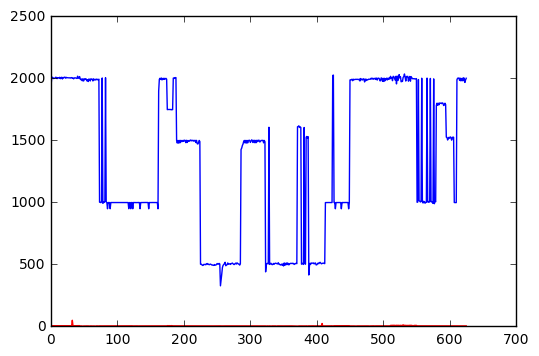

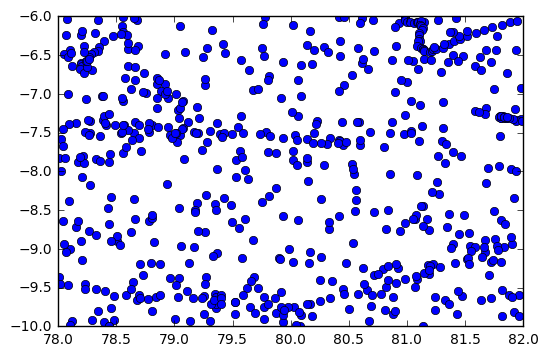

-7.6265 80.0135002136


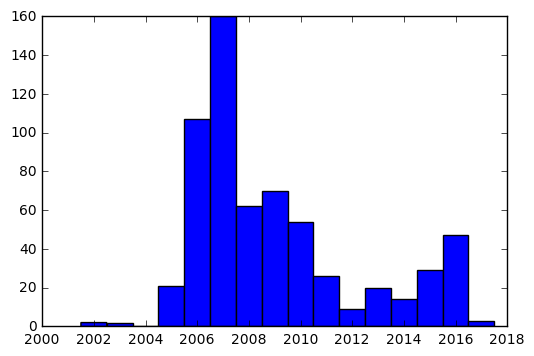

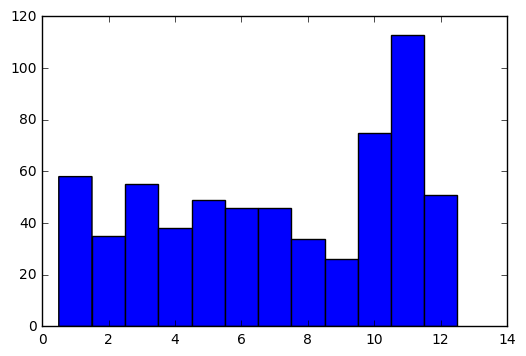

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
#plt.figure()
#plt.plot(N2,-pmid)
#plt.show()
#print np.min(N2)
plt.figure()
plt.plot(pmax, 'b')
plt.plot(pmin, 'r')
plt.show()
plt.figure()
plt.plot(lons, lats, 'o')
plt.show()
print np.median(lats), np.median(lons)
plt.figure()
plt.hist(map(lambda x:x.year, num2date(juld)), bins=np.arange(2002, 2019), align="left")
plt.show()
plt.figure()
plt.hist(map(lambda x:x.month, num2date(juld)), bins=np.arange(1,14), align="left")
plt.show()
# juld[map(lambda x:x.month, num2date(juld)) == 12]
# plt.figure(), plt.plot(map(lambda x:x.month, num2date(juld))), plt.show()

In [18]:
months = np.array(np.array(map(lambda x:x.month, num2date(juld))))
years = np.array(map(lambda x:x.year, num2date(juld)))

(array([ 0.,  0.,  2.,  1.,  3.,  3.,  3.,  1.,  0.,  0.,  0.,  1.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 12 Patch objects>)

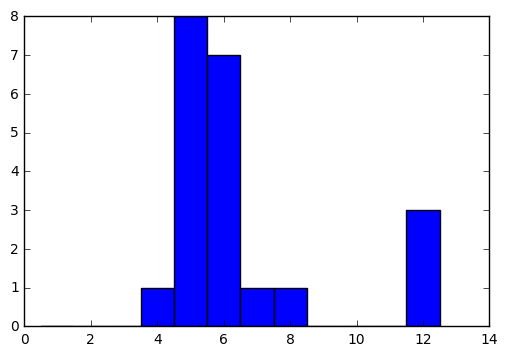

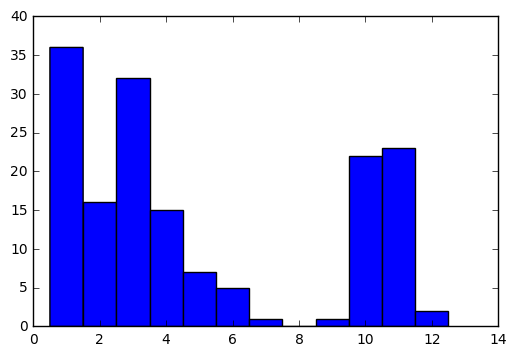

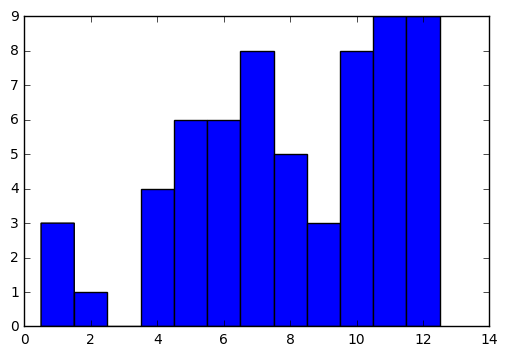

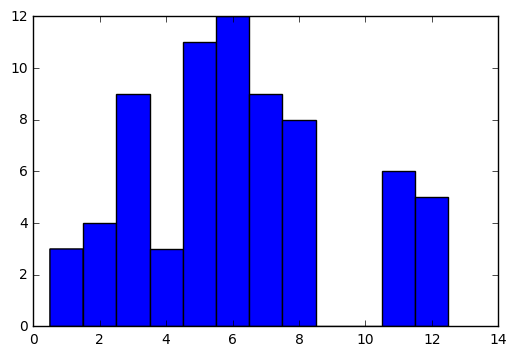

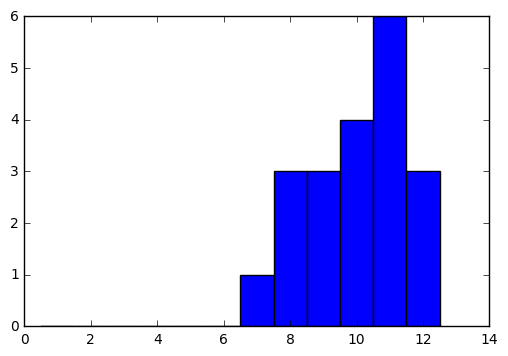

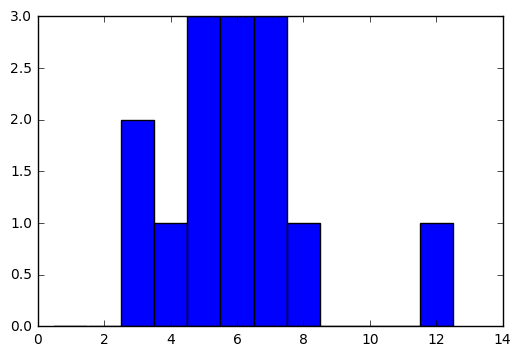

In [19]:
plt.figure()
plt.hist(months[years == 2005], bins=np.arange(1,14), align="left")
plt.figure()
plt.hist(months[years == 2007], bins=np.arange(1,14), align="left")
plt.figure()
plt.hist(months[years == 2008], bins=np.arange(1,14), align="left")
plt.figure()
plt.hist(months[years == 2009], bins=np.arange(1,14), align="left")
plt.figure()
plt.hist(months[years == 2013], bins=np.arange(1,14), align="left")
plt.figure()
plt.hist(months[years == 2014], bins=np.arange(1,14), align="left")
#plt.figure()
#plt.hist(months[years == 2010], bins=np.arange(1,14), align="left")
#print months[years == 2010], len(months[years == 2010])
#plt.figure()
#plt.hist(months[years == 2011], bins=np.arange(1,14), align="left")
#plt.figure()
#plt.hist(months[years == 2016], bins=np.arange(1,14), align="left")

(0, 150)

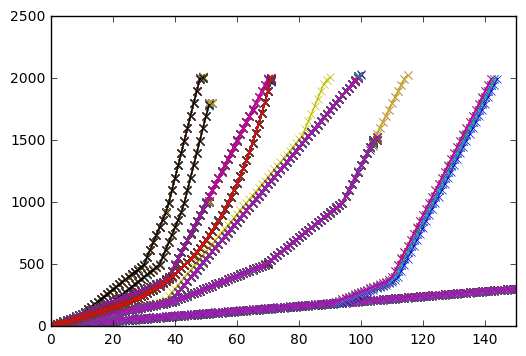

In [174]:
# need area average at every month of every year (time data)
# to do that (ALL) profiles need to be interpolated to a common vertical grid
# determine the vertical grid based typical pressure profile
pres = zip(*argo_profs)[10]
plt.figure()
dz = []
for n in range(len(pres)):
    plt.plot(pres[n], '-x')
    dz.append(np.gradient(pres[n]))
plt.xlim([0, 150])

(0, 150)

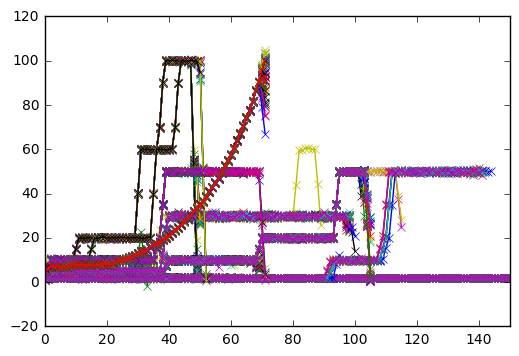

In [175]:
plt.figure()
for n in range(len(pres)):
    plt.plot(dz[n], '-x')
plt.xlim([0, 150])

In [176]:
DZ = [x.tolist() for x in dz]
P = [x.tolist() for x in pres]
DZ = [item for sublist in dz for item in sublist if item is not None or item is not nan]
P = [item for sublist in pres for item in sublist if item is not None]
#import itertools
#DZ = list(itertools.chain.from_iterable(DZ)) 
#P = list(itertools.chain.from_iterable(P))
DZ = np.asanyarray(DZ)
P = np.asanyarray(P)
#print orca[np.isnan(orca) is False].min()
DZ = np.ma.masked_where(np.isnan(DZ), DZ)
P = np.ma.masked_where(np.isnan(P), P)

-1.75 104.699951172 2.29999995232 2036.0
(149581,) (149581,)


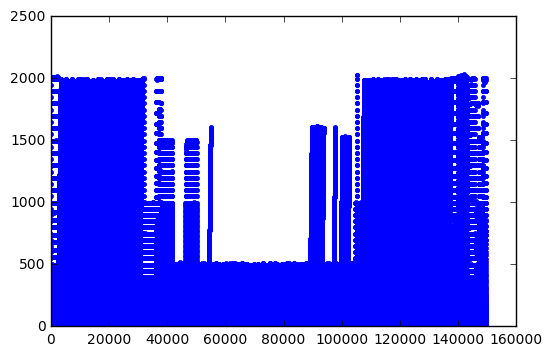

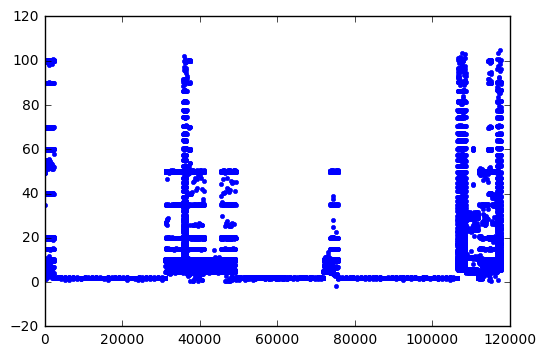

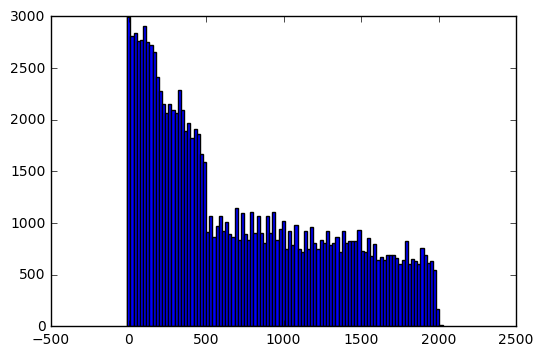

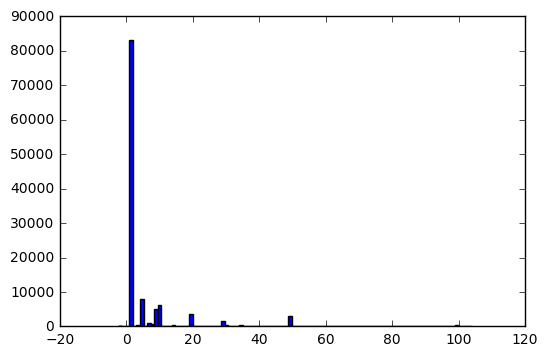

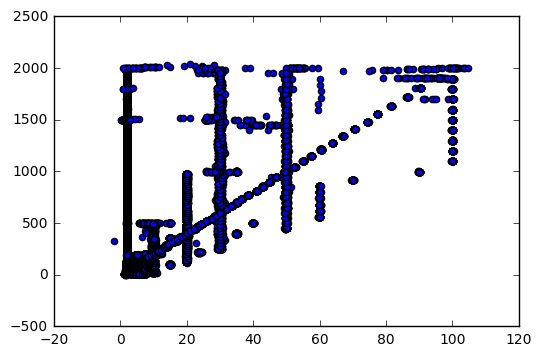

In [180]:
print DZ.min(), DZ.max(), P.min(), P.max()
print P.shape, DZ.shape

plt.figure()
plt.plot(P, '.')
plt.figure()
plt.plot(DZ.compressed(), '.')
plt.figure()
plt.hist(P.compressed(), bins=100, align="left")
plt.figure()
plt.hist(DZ.compressed(), bins=100, align="left")
plt.figure()
plt.scatter(DZ, P)

In [124]:
# just to learn/test some list of list operations (merge)
#xupa = [item for sublist in dz for item in sublist] # [leaf for tree in forest for leaf in tree] 
#import operator
#xupa2 = reduce(operator.concat, DZ)
#import itertools
#xupa3 = list(itertools.chain.from_iterable(DZ)) 

ModeResult(mode=array([ 2.]), count=array([78338]))
2.0
7.10953762196
104.699951172
4701
4700


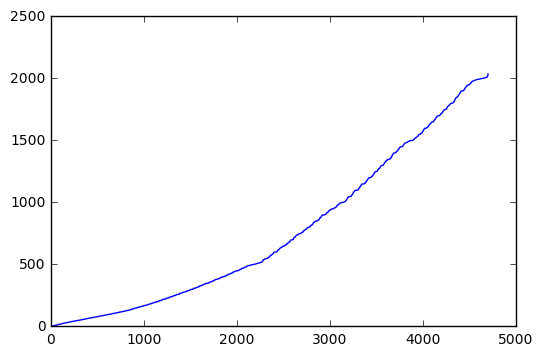

In [211]:
from scipy import stats
print stats.mode(DZ.compressed())
print np.median(DZ.compressed())
print np.mean(DZ.compressed())
print np.max(DZ.compressed())
print len(np.ma.unique(P))
print len(set(P.compressed()))
plt.figure
plt.plot(np.ma.unique(P))
#plt.plot(list(set(P.compressed())))
#print list(set(P.compressed()))

In [228]:
# a new pressure grid:
pnew_min, pnew_dz, pnew_ml, pnew_dz_tc, pnew_tc = 2., 2., 50., 5., 200.
pnew_dz_dtc, pnew_, pnew_dz_mt, pnew_tc = 10., 500, 5., 200.

pnew = np.concatenate((np.arange(2., 52., 2.), np.arange(55., 205., 5.), np.arange(210.,510.,10.),
                      np.arange(510., 1025., 25.), np.arange(1050., 2050., 50)))
# or loop through the unique/set of pressure values (which capture most) then perform the spatial and/or time averages?

626

626
ModeResult(mode=array([72], dtype=int32), count=array([131]))
72.0
238.947284345


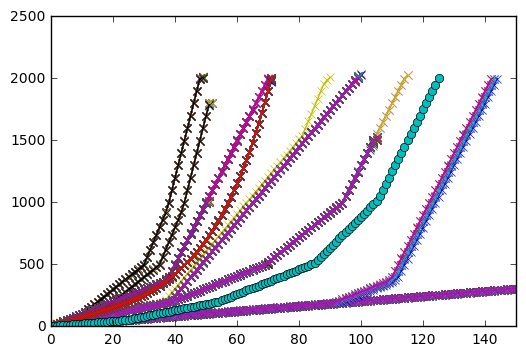

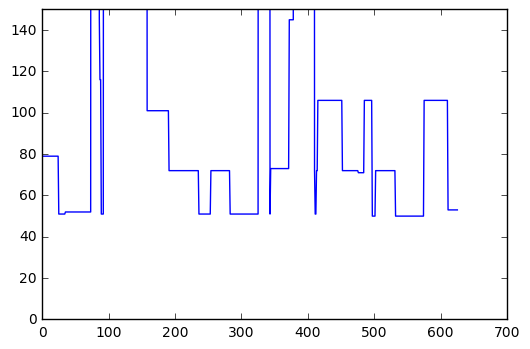

In [272]:
plt.figure()
for n in range(len(pres)):
    plt.plot(pres[n], '-x')
plt.plot(pnew, '-o', lw=2)
plt.xlim([0, 150])
print len(match)
plt.figure()
plt.plot(match["nlevs"])
plt.ylim([0, 150])
print stats.mode(match["nlevs"])
print np.median(match["nlevs"])
print np.mean(match["nlevs"])

The new pressure coord is less than ideal; too much resolution than what is typically apparent, lets see what the data suggest as the most common pressure distribution.

We learned above that the most frequent number of pressure levels (nlevs) is 72. Now let's see how those cover the 2000 db domain.

In [294]:
#suckit = match["nlevs"] # using match database is useless since we are now using the argo_prof list
suckit = [len(x) for x in pres]
print len(suckit)
print min(suckit), max(suckit)
suckit = np.array(suckit)
print suckit[suckit==72] # also stay with only if profile sampled to 2000
print len(suckit[suckit==72])
print np.where(suckit == 72)
#print len(np.where(match["nlevs"]==72)[0]) # this is wrong
#nega = np.where(match["nlevs"]==72)[0]
print len(np.where(suckit==72)[0])
nega = np.where(suckit==72)[0] # need this because tuple of pressure profiles only take integer index
nega.shape
print suckit[nega]
dpmax = np.zeros_like(suckit[nega])
for n in range(len(nega)):
    dpmax[n] = pres[nega[n]].max()
print dpmax
print nega[dpmax>=1900]

626
50 1000
[72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72 72
 72 72 72 72 72 72]
131
(array([ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
       268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 481, 482, 483, 484, 485, 486, 487, 488,
       489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501,
       502, 503, 504, 505, 506, 507, 508, 509, 510, 551, 552, 553, 554,
       555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567,
       

5.6 100.3
4.70007 50.6


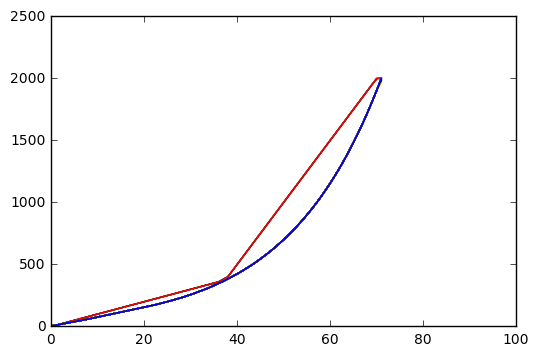

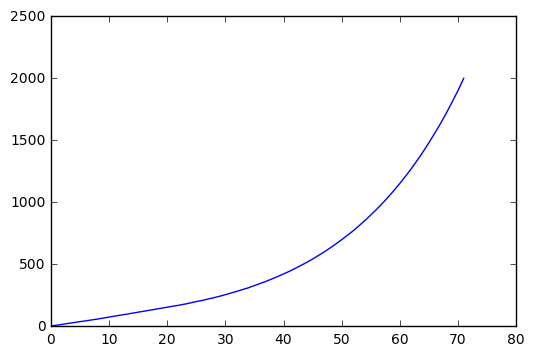

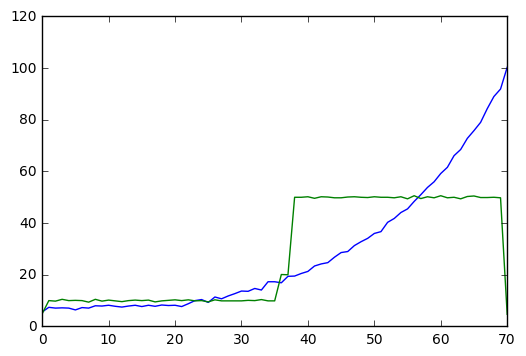

In [304]:
plt.figure()
for n in nega[dpmax>=1900]:
    plt.plot(pres[n])
    # print n, len(pres[n]) # was for debugging
plt.xlim([0, 100])
plt.figure()
plt.plot(pres[nega[dpmax>=1900][-1]])
plt.figure()
plt.plot(np.diff(pres[nega[dpmax>=1900][-1]]))
plt.plot(np.diff(pres[nega[dpmax>=1900][0]]))
print np.min(np.diff(pres[nega[dpmax>=1900][-1]])), np.max(np.diff(pres[nega[dpmax>=1900][-1]]))
print np.min(np.diff(pres[nega[dpmax>=1900][0]])), np.max(np.diff(pres[nega[dpmax>=1900][0]]))

The green/red curve is a coarser version of the initial new pressure coordinate.

Something like the blue curves look very generic. Let's use that to regrid all profiles (of the quantities of interest).

In [ ]:
pnew = pres[nega[dpmax>=1900][-1]]  # later compare with pnew of higher resolution
def argo_prof_regrid(pnew):
    S = np.empty((len(argo_profs), len(pnew)))
    T = np.empty((len(argo_profs), len(pnew)))
    SA = np.empty((len(argo_profs), len(pnew)))
    CT = np.empty((len(argo_profs), len(pnew)))
    Theta = np.empty((len(argo_profs), len(pnew)))
    sig_theta = np.empty((len(argo_profs), len(pnew)))
    Nsq = np.empty((len(argo_profs), len(pnew)))
    Nsq_beta = np.empty((len(argo_profs), len(pnew)))
    Nsq_alpha = np.empty((len(argo_profs), len(pnew)))
    for n in range(0, len(argo_profs)):
        S[n, :] = np.interp(pnew, argo_profs[n][10].compressed(), argo_profs[n][15].compressed(), left=np.nan, right=np.nan)
        T[n, :] = np.interp(pnew, argo_profs[n][10].compressed(), argo_profs[n][20].compressed(), left=np.nan, right=np.nan)
        SA[n, :] = np.interp(pnew, argo_profs[n][10].compressed(), argo_profs[n][25].compressed(), left=np.nan, right=np.nan)
        CT[n, :] = np.interp(pnew, argo_profs[n][10].compressed(), argo_profs[n][26].compressed(), left=np.nan, right=np.nan)
        Theta[n, :] = np.interp(pnew, argo_profs[n][10].compressed(), argo_profs[n][27].compressed(), left=np.nan, right=np.nan)
        sig_theta[n, :] = np.interp(pnew, argo_profs[n][10].compressed(), argo_profs[n][28].compressed(), left=np.nan, right=np.nan)
        Nsq[n, :] = np.interp(pnew, argo_profs[n][-1].compressed(), argo_profs[n][29].compressed(), left=np.nan, right=np.nan)
        Nsq_beta[n, :] = np.interp(pnew, argo_profs[n][-1].compressed(), argo_profs[n][30].compressed(), left=np.nan, right=np.nan)
        Nsq_alpha[n, :] = np.interp(pnew, argo_profs[n][-1].compressed(), argo_profs[n][31].compressed(), left=np.nan, right=np.nan)
    # now apply a mask for the nan
    S, T, SA, CT, Theta, sig_theta, Nsq, Nsq_beta, Nsq_alpha = map(np.ma.masked_invalid, [S, T, SA, CT, Theta,
                                                                                          sig_theta, Nsq, Nsq_beta,
                                                                                          Nsq_alpha])
    return S, T, SA, CT, Theta, sig_theta, Nsq, Nsq_beta, Nsq_alpha
S, T, SA, CT, Theta, sig_theta, Nsq, Nsq_beta, Nsq_alpha = argo_prof_regrid(pnew)

In [ ]:
len(argo_profs)

In [ ]:
(np.ma.masked_invalid(argo_profs[222][10]) == argo_profs[222][10]).all()

In [339]:
argo_profs[222][1]

-8.3390000000000004